# GeoTracks: спрос, маршруты, аномалии и прогноз

Готовый ноутбук: загрузка данных → фичи → визуализации (heatmaps) → модели (лаговый бейзлайн и CatBoost) → сравнение → выводы.

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor, Pool

In [4]:
df = pd.read_csv('data/geo_locations_astana_hackathon.csv')

# Приводим числовые колонки
for col in ['lat','lng','alt','spd','azm']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=['lat','lng']).copy()

# Таймстамп — используем существующий или создаём синтетический
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
else:
    origin = pd.Timestamp("2025-01-01 00:00:00")
    if 'randomized_id' not in df.columns:
        df['randomized_id'] = 0
    df = df.reset_index(drop=False).rename(columns={'index':'row_id'})
    df = df.sort_values(['randomized_id','row_id'])
    df['row_in_user'] = df.groupby('randomized_id').cumcount()
    df['timestamp'] = origin + pd.to_timedelta(df['row_in_user'] * 5, unit='s')

df = df.dropna(subset=['timestamp']).copy()
print(df.head())

       row_id        randomized_id        lat        lng         alt  \
44873   44873 -9221304899272910788  51.082958  71.422355  327.900000   
44877   44877 -9221304899272910788  51.083456  71.422540  328.100000   
62024   62024 -9221304899272910788  51.087376  71.419481  321.400024   
84954   84954 -9221304899272910788  51.094377  71.426454  316.700012   
84957   84957 -9221304899272910788  51.087719  71.424072  316.700012   

             spd         azm  row_in_user           timestamp  
44873  14.299938  192.527924            0 2025-01-01 00:00:00  
44877   9.501606  191.521332            1 2025-01-01 00:00:05  
62024   0.264234  200.035172            2 2025-01-01 00:00:10  
84954  18.566868  192.994232            3 2025-01-01 00:00:15  
84957   2.171384  195.699677            4 2025-01-01 00:00:20  


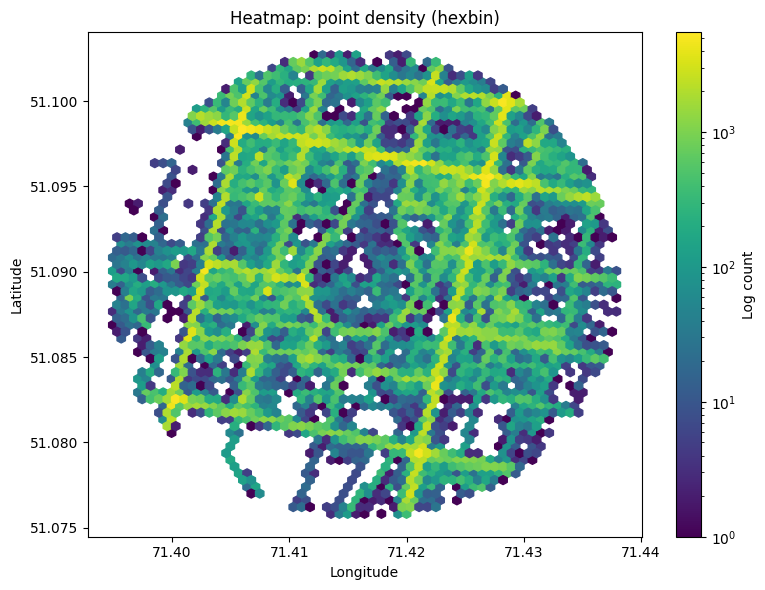

C:\Users\Daulet\AppData\Local\Temp\ipykernel_8004\1647462880.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['dt_hour'] = df['timestamp'].dt.floor('H')


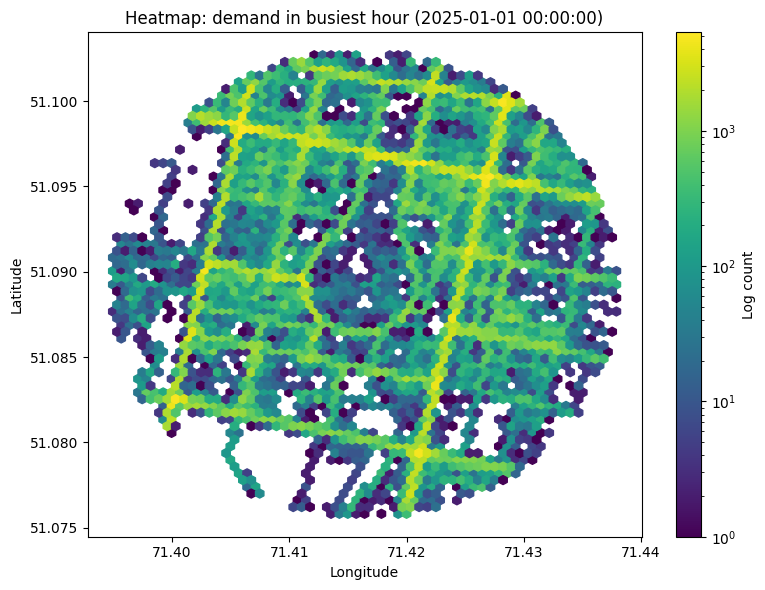

In [5]:
# HEATMAPS
plt.figure(figsize=(8,6))
plt.hexbin(df['lng'], df['lat'], gridsize=60, bins='log')
plt.colorbar(label="Log count")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Heatmap: point density (hexbin)")
plt.tight_layout()
plt.show()

# Сетка для часового спроса
LAT_SCALE = 200
LNG_SCALE = 200
df['cell_lat'] = (df['lat'] * LAT_SCALE).astype(int)
df['cell_lng'] = (df['lng'] * LNG_SCALE).astype(int)
df['cell'] = df['cell_lat'].astype(str) + "_" + df['cell_lng'].astype(str)
df['dt_hour'] = df['timestamp'].dt.floor('H')

hour_counts = df.groupby('dt_hour').size().sort_values(ascending=False)
top_hour = hour_counts.index[0] if len(hour_counts) else df['dt_hour'].iloc[0]

grid_hour = df[df['dt_hour'] == top_hour]

plt.figure(figsize=(8,6))
plt.hexbin(grid_hour['lng'], grid_hour['lat'], gridsize=60, bins='log')
plt.colorbar(label="Log count")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Heatmap: demand in busiest hour ({top_hour})")
plt.tight_layout()
plt.show()

In [6]:
# Агрегируем спрос по (cell, hour)
demand = (
    df.groupby(['cell', 'dt_hour'])
      .size()
      .reset_index(name='target')
)
demand['hour'] = demand['dt_hour'].dt.hour
demand['weekday'] = demand['dt_hour'].dt.weekday

# Лаги и скользящие окна
demand = demand.sort_values(['cell','dt_hour']).copy()
demand['lag_1h'] = demand.groupby('cell')['target'].shift(1)
demand['lag_2h'] = demand.groupby('cell')['target'].shift(2)
demand['lag_24h'] = demand.groupby('cell')['target'].shift(24)
for w in [3,6,12,24]:
    demand[f'roll_mean_{w}h'] = (
        demand.groupby('cell')['target']
              .shift(1).rolling(window=w, min_periods=1).mean()
              .reset_index(level=0, drop=True)
    )

# Заполняем NaN фичей нулями
feature_cols = ['cell','hour','weekday','lag_1h','lag_2h','lag_24h','roll_mean_3h','roll_mean_6h','roll_mean_12h','roll_mean_24h']
demand[feature_cols[3:]] = demand[feature_cols[3:]].fillna(0)

# Разделение по времени (последние 20% часов в тест)
demand = demand.sort_values(['dt_hour','cell']).reset_index(drop=True)
unique_hours = demand['dt_hour'].sort_values().unique()
split_idx = int(len(unique_hours)*0.8) if len(unique_hours) > 1 else 0
train_hours = set(unique_hours[:split_idx])
test_hours = set(unique_hours[split_idx:])

train_df = demand[demand['dt_hour'].isin(train_hours)].copy()
test_df  = demand[demand['dt_hour'].isin(test_hours)].copy()

X_train = train_df[feature_cols]
y_train = train_df['target'].astype(float)
X_test  = test_df[feature_cols]
y_test  = test_df['target'].astype(float)

print(f"Train rows: {len(train_df)}, Test rows: {len(test_df)}")

Train rows: 278, Test rows: 24


In [7]:
# БЕЙЗЛАЙН: лаг-1 (если нет лаг-1, берём глобальное среднее из train)
global_mean = y_train.mean()
y_pred_naive = test_df['lag_1h'].fillna(global_mean).values

def metrics(y, yhat):
    mae = mean_absolute_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    smape = (2*np.abs(y - yhat) / (np.abs(y) + np.abs(yhat) + 1e-9)).mean()
    return mae, rmse, smape

mae_n, rmse_n, smape_n = metrics(y_test, y_pred_naive)
print(f"Naive Lag-1 — MAE: {mae_n:.2f} | RMSE: {rmse_n:.2f} | sMAPE: {smape_n*100:.2f}%")

Naive Lag-1 — MAE: 28.21 | RMSE: 74.69 | sMAPE: 97.52%


In [8]:
# CATBOOST: лог-трансформация цели + ограничение кардинальности 'cell' для скорости
demand2 = demand.copy()
q99 = np.quantile(demand2['target'], 0.99) if len(demand2) > 10 else demand2['target'].max()
demand2['target_clipped'] = np.minimum(demand2['target'], q99)

# пересобираем лаги/роллы на clipped для согласованности
demand2 = demand2.sort_values(['cell','dt_hour']).copy()
for col in ['lag_1h','lag_2h','lag_24h','roll_mean_3h','roll_mean_6h','roll_mean_12h','roll_mean_24h']:
    if col in demand2.columns:
        demand2.drop(columns=[col], inplace=True)

demand2['lag_1h']  = demand2.groupby('cell')['target_clipped'].shift(1)
demand2['lag_2h']  = demand2.groupby('cell')['target_clipped'].shift(2)
demand2['lag_24h'] = demand2.groupby('cell')['target_clipped'].shift(24)
for w in [3,6,12,24]:
    demand2[f'roll_mean_{w}h'] = (
        demand2.groupby('cell')['target_clipped']
               .shift(1).rolling(window=w, min_periods=1).mean()
               .reset_index(level=0, drop=True)
    )

feature_cols2 = ['cell','hour','weekday','lag_1h','lag_2h','lag_24h','roll_mean_3h','roll_mean_6h','roll_mean_12h','roll_mean_24h']
demand2[feature_cols2[3:]] = demand2[feature_cols2[3:]].fillna(0)

# reduce categories for 'cell'
topN = 200
top_cells = set(demand2['cell'].value_counts().head(topN).index)
demand2.loc[~demand2['cell'].isin(top_cells), 'cell'] = '_other_'

# split by time
unique_hours2 = demand2['dt_hour'].sort_values().unique()
split_idx2 = int(len(unique_hours2)*0.8) if len(unique_hours2)>1 else 0
train_hours2 = set(unique_hours2[:split_idx2])
test_hours2  = set(unique_hours2[split_idx2:])

train2 = demand2[demand2['dt_hour'].isin(train_hours2)].copy()
test2  = demand2[demand2['dt_hour'].isin(test_hours2)].copy()

Xtr = train2[feature_cols2]
Xte = test2[feature_cols2]
ytr_raw = train2['target_clipped'].astype(float)
yte_raw = test2['target_clipped'].astype(float)

ytr = np.log1p(ytr_raw)
yte = np.log1p(yte_raw)

pool_tr = Pool(Xtr, ytr, cat_features=['cell','hour','weekday'])
pool_te = Pool(Xte, yte, cat_features=['cell','hour','weekday'])

model = CatBoostRegressor(
    iterations=600,
    depth=6,
    learning_rate=0.2,
    l2_leaf_reg=6.0,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    od_type='Iter',
    od_wait=60,
    rsm=0.8,
    verbose=100
)
model.fit(pool_tr, eval_set=pool_te, use_best_model=True)

y_pred_log = model.predict(pool_te)
y_pred = np.expm1(y_pred_log)

mae_c = mean_absolute_error(yte_raw, y_pred)
rmse_c = np.sqrt(mean_squared_error(yte_raw, y_pred))
smape_c = (2*np.abs(yte_raw - y_pred) / (np.abs(yte_raw)+np.abs(y_pred)+1e-9)).mean()

print(f"CatBoost — MAE: {mae_c:.2f} | RMSE: {rmse_c:.2f} | sMAPE: {smape_c*100:.2f}%")

# Сравнение с бейзлайном
labels = ['Lag-1', 'CatBoost']
maes = [ ]
maes.append(mae_n)
maes.append(mae_c)
print('MAE comparison:', maes)

0:	learn: 2.5018696	test: 3.1883556	best: 3.1883556 (0)	total: 178ms	remaining: 1m 46s
100:	learn: 0.4646802	test: 1.4044404	best: 1.3871159 (90)	total: 4.3s	remaining: 21.3s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 1.380036691
bestIteration = 104

Shrink model to first 105 iterations.
CatBoost — MAE: 32.99 | RMSE: 71.99 | sMAPE: 96.86%
MAE comparison: [28.208333333333332, 32.985701705643635]


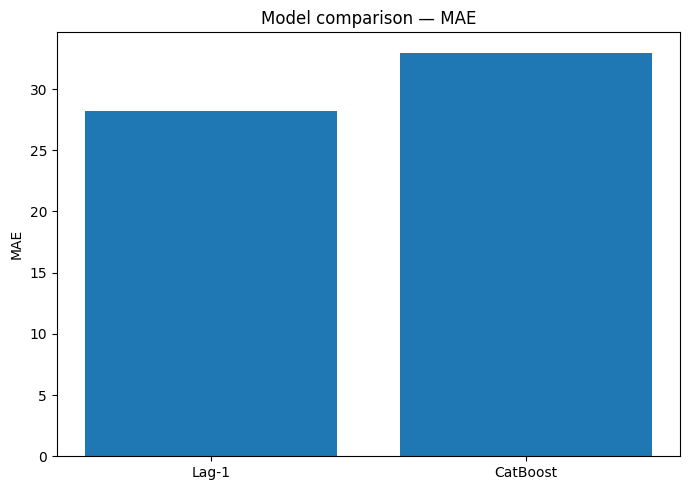

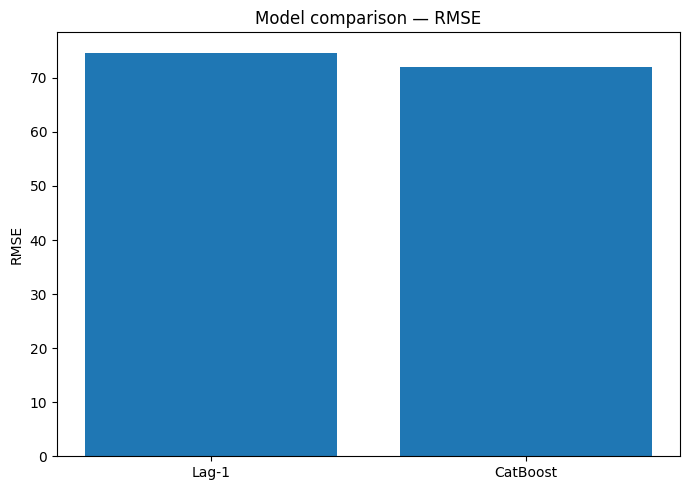

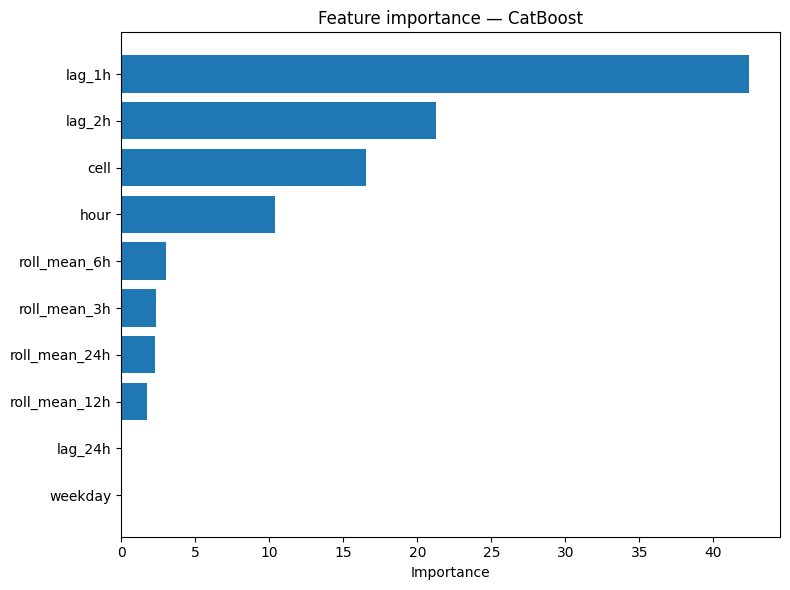

In [9]:
# Барчарты сравнения
plt.figure(figsize=(7,5))
plt.bar(['Lag-1','CatBoost'], [mae_n, mae_c])
plt.ylabel("MAE")
plt.title("Model comparison — MAE")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
plt.bar(['Lag-1','CatBoost'], [rmse_n, rmse_c])
plt.ylabel("RMSE")
plt.title("Model comparison — RMSE")
plt.tight_layout()
plt.show()

# Важность признаков CatBoost
fi = model.get_feature_importance(pool_tr, type='FeatureImportance')
feat_names = Xtr.columns.tolist()
order = np.argsort(fi)
plt.figure(figsize=(8,6))
plt.barh(np.array(feat_names)[order], np.array(fi)[order])
plt.xlabel("Importance")
plt.title("Feature importance — CatBoost")
plt.tight_layout()
plt.show()

## Выводы
- Построены две тепловые карты: общая плотность точек и спрос в самый загруженный час.
- Бейзлайн **Lag-1** часто силён на краткосрочных геоданных и даёт ориентир качества.
- **CatBoost** с лог-трансформацией цели и лагами/роллами — конкурентный вариант; дальше можно добавить соседние ячейки, погоду и события.
- Код учитывает анонимизацию (работаем только с агрегатами по сетке).